# Astronomy Department Friday Pizzas

Below we explore the financials and ordering strategies for the Friday pizza orders. These data were collected weekly since ~2011, though many records were incomplete and were discarded. To be considered complete and included in the following analysis, the pizza entry must include: 

* Number of pizzas ordered

* Number of pizzas left after end of sale

* Money spent on the pizza

* Money collected

[The source data](https://github.com/bmorris3/astropizzafridayfuntimes/blob/master/pizzadata.csv) are available in a CSV file in our [repository on GitHub](https://github.com/bmorris3/astropizzafridayfuntimes).

In [7]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['font.size'] = 14
from matplotlib import pyplot as plt

import numpy as np
import datetime
from astropy.io import ascii
from astropy.time import Time

pizza_data_table = ascii.read('pizzadata.csv')

# dates.append(datetime.datetime(year, mm, dd))
# pizzasordered.append(float(splitline[1]))
# pizzasleft.append(float(splitline[2]))
# moneyout.append(float(splitline[3]))
# moneyin.append(float(splitline[4]))

dates = Time(pizza_data_table['Date'].data)
pizzas_ordered = pizza_data_table['Number pizzas ordered']
pizzas_left = pizza_data_table['Number Pizzas left']
pizzas_ordered_minus_left = pizzas_ordered - pizzas_left
money_spent = pizza_data_table['Money Spent']
money_received = pizza_data_table['Money Received']

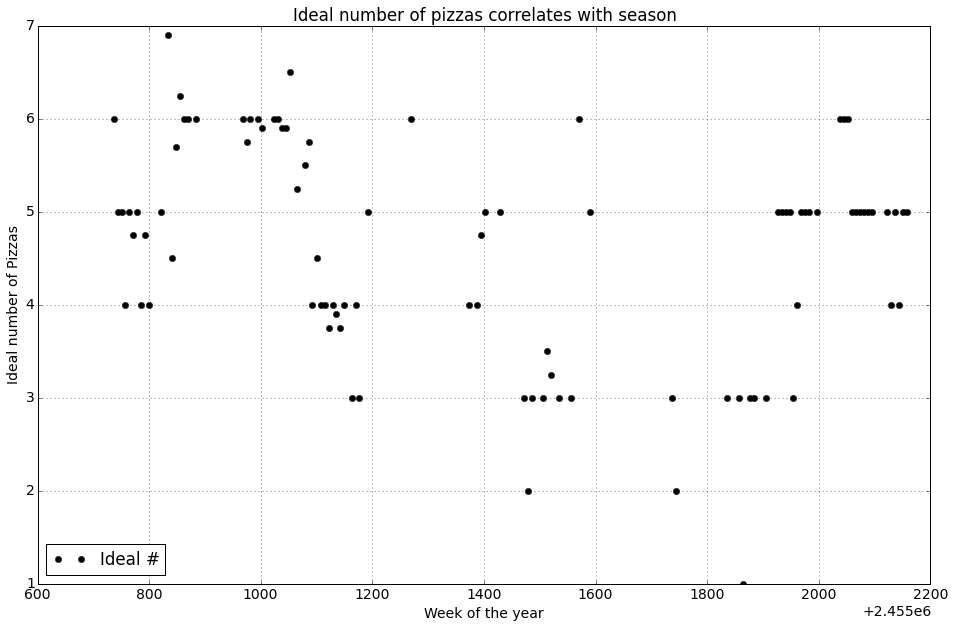

In [33]:
fig, ax = plt.subplots(1,figsize=(16,10))
ax.plot(dates.jd, pizzas_ordered_minus_left, 'ko', label='Ideal #')
#ax.plot(weather_months*4 + 2, cloudcover, lw=2, color='b', label='Octal Cloud Cover')

# ax.fill_between([int(datetime.datetime(2014,6,12).strftime('%U')), \
#                  int(datetime.datetime(2014,9,25).strftime('%U'))],\
#                  0, 8, facecolor='yellow', alpha=0.2,
#                  label='Summer')
# ax.annotate('Summer quarter', (30, 7.5), textcoords='data', ha='center', fontsize=15)

ax.set_ylabel('Ideal number of Pizzas')
ax.set_xlabel('Week of the year')
ax.set_title('Ideal number of pizzas correlates with season')
ax.grid()
#ax.set_xlim([0,52])
ax.legend(loc='lower left')
plt.show()

## How much money was made or lost overall?

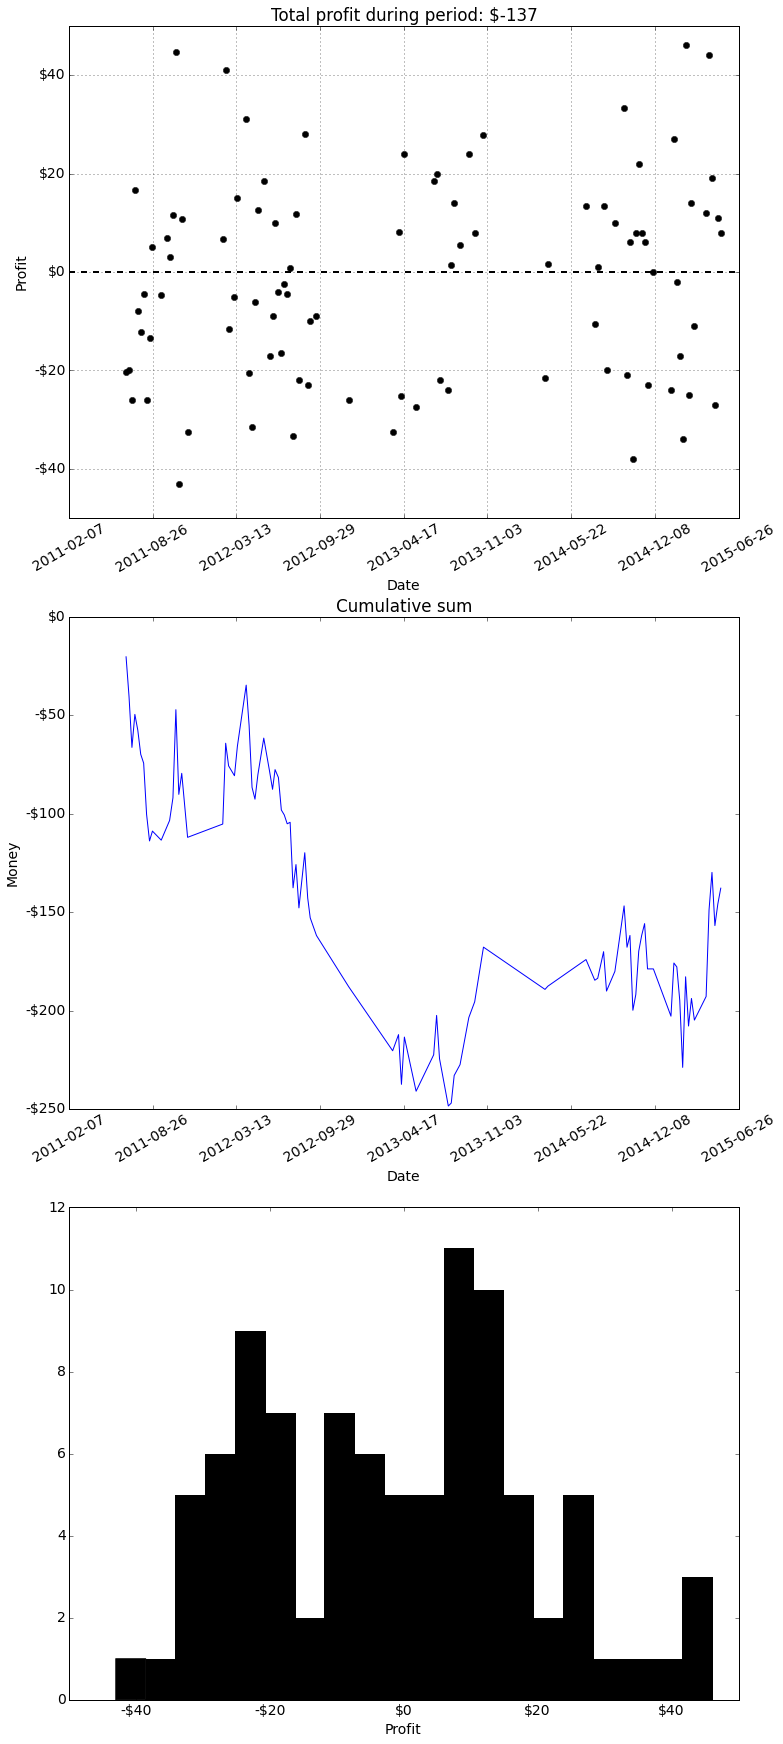

In [23]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(3, 1, figsize=(12, 30))
ax[0].plot(dates.jd, money_spent-money_received, 'ok')
xaxisrange = range(2011,2016)
#ax.set_xticks(xaxisrange)
#ax.set_xticklabels(list(map(str,xaxisrange)))

def moneyformat(dollars, pos):
    if dollars < 0:
        return '-$%d' % np.abs(dollars)
    else: 
        return '$%d' % dollars

y_formatter = FuncFormatter(moneyformat)
ax[0].yaxis.set_major_formatter(y_formatter)

def dateformat(jd, pos):
    return Time(jd, format='jd').datetime.date()

x_formatter = FuncFormatter(dateformat)
ax[0].xaxis.set_major_formatter(x_formatter)

ax[0].set(title='Total profit during period: $%d' % np.sum(money_spent-money_received),
          ylabel='Profit', xlabel='Date')
ax[0].grid()
ax[0].axhline(0, lw=2, ls='--', color='k')


ax[1].plot(dates.jd, np.cumsum(money_spent-money_received))
ax[1].xaxis.set_major_formatter(x_formatter)
ax[1].yaxis.set_major_formatter(y_formatter)
ax[1].set(title='Cumulative sum', 
          xlabel='Date', ylabel='Money')

ax[2].hist(money_spent-money_received, 20, facecolor='k')
ax[2].xaxis.set_major_formatter(y_formatter)
ax[2].set(xlabel='Profit')
for axis in ax[:-1]: 
    [l.set_rotation(30) for l in axis.xaxis.get_ticklabels()]
plt.show()

# Model

In [87]:
import emcee
import george
from george import kernels

singlepointerror = 0.5*np.ones(len(dates))

newyearsday = Time('2014-01-01 00:00').jd

def fitfunc(p, x=dates.jd):#, x0=newyearsday):
    return p[0]*np.cos(2*np.pi*x/365.0 - p[1]) + p[2]

def lnprior(p):
    '''
    Constrain cosinusoidal parameters to be positive, 
    and periodicity < 2 years
    '''
    if all(p[:-1] > 0) and np.pi/2 < p[1] < 3./2*np.pi:
        return 0
    else: 
        return -np.inf

def lnprob(p, t=dates.jd):
    lp = lnprior(p)
    if np.isfinite(lp):
        w = np.exp(p[-1])
        gp = george.GP(kernels.WhiteKernel(w), solver=george.HODLRSolver)
        gp.compute(t, singlepointerror)
        return lp + gp.lnlikelihood(pizzas_ordered_minus_left - fitfunc(p, t))
    return lp

initP = [0.5, np.pi, 4.8, -0.3]
burnin = 0.5
Nsteps = 2000

ndim, nwalkers = len(initP), 150
def rand(initP=initP, ndim=ndim):
    return np.abs(initP)*np.random.rand(ndim)

p0 = [0.5*rand() + initP for i in range(nwalkers)]
n_threads = 4
pool = emcee.interruptible_pool.InterruptiblePool(processes=n_threads)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
sampler.run_mcmc(p0, Nsteps)

chains = sampler.flatchain[int(burnin*Nsteps):,:]

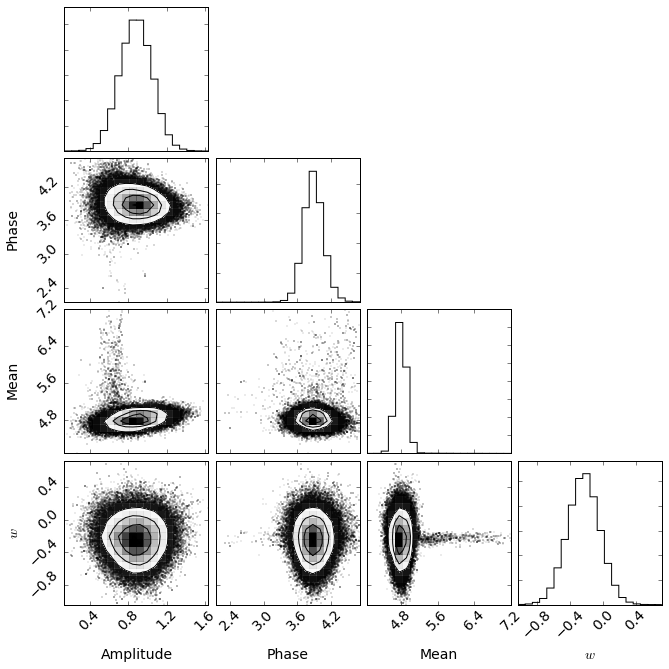

In [88]:
import corner
corner.corner(chains,labels=['Amplitude', 'Phase', 'Mean', '$w$']);

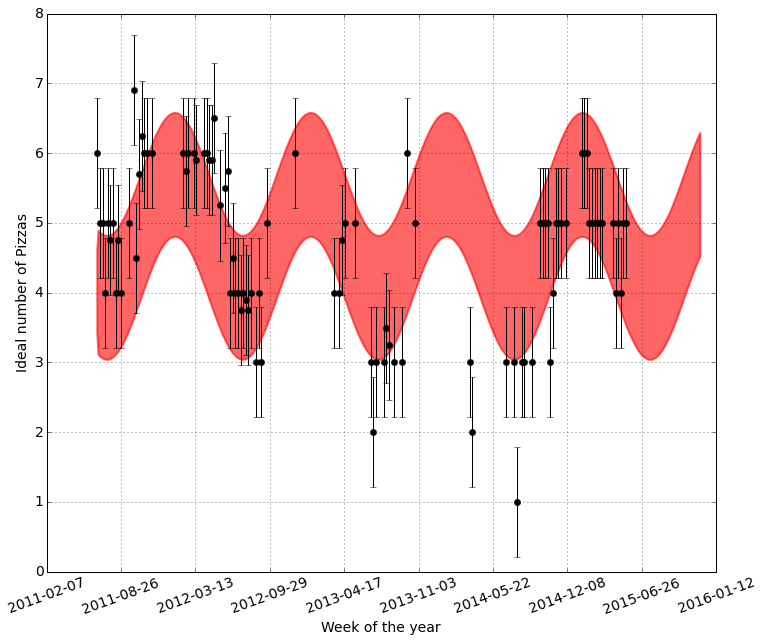

In [111]:
bestparams = np.median(chains, axis=0)
bestfitmodel = fitfunc(bestparams)
#print('Amp: {0}, Mean: {1}, Noise: {2}'.format(*bestparams))

x = np.arange(53)
gp = george.GP(kernels.WhiteKernel(np.exp(np.median(chains[:,-1]))))
gp.compute(dates.jd, np.exp(bestparams[-1]))

dates_plus_prediction = np.linspace(dates.jd.min(), dates.jd.max()+200, 500)
mu, cov = gp.predict(bestfitmodel, dates_plus_prediction)#dates.jd)
std = np.sqrt(np.diag(cov))

fig, ax = plt.subplots(1,figsize=(12,10))

ax.errorbar(dates.jd, pizzas_ordered_minus_left, np.exp(bestparams[-1])*np.ones_like(dates.jd),
            color='k', fmt='o', label='Ideal #')

ax.fill_between(dates_plus_prediction, 
                fitfunc(bestparams, x=dates_plus_prediction)-std, 
                fitfunc(bestparams, x=dates_plus_prediction)+std, lw=2, 
                color='r', label='Model', alpha=0.6)

ax.set_ylabel('Ideal number of Pizzas')
ax.set_xlabel('Week of the year')
#ax.set_title('Gaussian Process Model')
ax.grid()
ax.xaxis.set_major_formatter(x_formatter)
[l.set_rotation(20) for l in ax.get_xticklabels()]
#ax.legend(loc='lower left')
plt.show()

## Excess of pizzas ordered

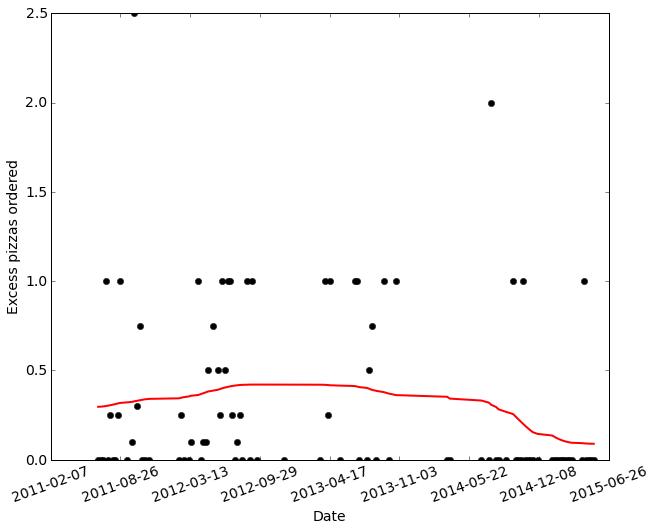

In [109]:
from scipy.ndimage import gaussian_filter
fig, ax = plt.subplots(1, figsize=(10,8))
ax.plot(dates.jd, pizzas_left.data, 'ko')
ax.plot(dates.jd, gaussian_filter(pizzas_left.data, 10), 'r', lw=2)
ax.xaxis.set_major_formatter(x_formatter)
[l.set_rotation(20) for l in ax.get_xticklabels()]
ax.set(xlabel='Date', ylabel='Excess pizzas ordered')
plt.show()